# Make illustration of volume, mortality, and N* with O2


In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from config_calc import *
plt.rcParams['mathtext.default']='regular'

dataroot = '/glade/p/ncgd0033/obs'
#dataroot = '/project/oce/mclong'

Read a mask file that has basin definitions

In [2]:
mask_file_in = os.path.join(dataroot,'woa2013v2/1x1d/woa_region_mask.nc')
dsm = xr.open_dataset(mask_file_in)
dsm

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, region: 5)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: region
Data variables:
    area            (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 ...
    mask            (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    kmt             (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    REGION_MASK_3D  (region, lat, lon) float64 nan nan nan nan nan nan nan ...
    region_names    (region) |S14 'Global' 'Pacific' 'Atlantic' 'Indian' ...

In [3]:
region_names = dsm.region_names.values
region_names

array(['Global', 'Pacific', 'Atlantic', 'Indian', 'Southern Ocean'], 
      dtype='|S14')

Read the WOA2013, annual mean datasets

In [4]:
woapth = os.path.join(dataroot,'woa2013v2/1x1d')

woa = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t00_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s00_01v2.nc')},
    'NO3' : {'varname': 'n_an', 'file': os.path.join(woapth,'woa13_all_n00_01.nc')},
    'PO4' : {'varname': 'p_an', 'file': os.path.join(woapth,'woa13_all_p00_01.nc')}}

ds = {}
for v,info in woa.items():   
    varname = info['varname']
    file_in = info['file']
    dsi = xr.open_dataset(file_in,decode_times=False)
    dsi = dsi.drop([k for k in dsi if k not in [varname,'lat','lon','depth','depth_bnds']])
    dsi = dsi.rename({varname:v})
    if ds:
        ds = xr.merge((ds,dsi))
    else:
        ds = dsi
         
ni = len(ds.lon)
nj = len(ds.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    ds[v] = ds[v] * mlperl_2_mmolm3
    ds[v].attrs['units'] = 'mmol m$^{-3}$'
ds

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    S           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2sat       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    T           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    NO3         (time, depth, lat, lon) float64

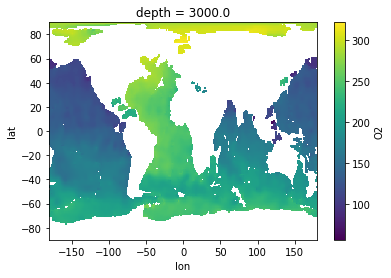

In [20]:
ds.O2.sel(depth=3000).isel(time=0).plot()

Compute some derived variables: `dz` is the cell vertical thickness, `n_deficit` is the N* tracer, and `vol` is the cell volume 

In [6]:
ds['dz'] = (ds.depth_bnds[:,1:] - ds.depth_bnds[:,:-1])[:,0]
ds['n_deficit'] = ds.NO3 - ds.PO4 * 16.
ds['vol'] = ds.dz * dsm.area
ds

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    S           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2sat       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    T           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    NO3         (time, depth, lat, lon) float64

Create a dictionary `regions` that has multiple masked copies of the WOA dataset

In [7]:
regions = {}
for i,name in enumerate(region_names):
    regions[name] = ds.where(dsm.REGION_MASK_3D[i,:,:]==1)
    
regions['Global']

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds, time
Data variables:
    depth_bnds  (depth, nbounds, lat, lon) float32 nan nan nan nan nan nan ...
    PO4         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    S           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2sat       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    AOU         (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    T           (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    O2          (time, depth, lat, lon) float64 nan nan nan nan nan nan nan ...
    NO3         (time, depth, lat, lon) float64 

Loop over the regions and compute sums and averages for `vol` and `n_deficit`

In [8]:
do2 = 1.
o2_bins = np.arange(0.,360.+do2,do2)

o2_binc = np.vstack((o2_bins[:-1],o2_bins[1:])).mean(axis=0)
o2_binc

vol_by_o2 = {}
no3def_by_o2 = {}
for name,dsr in regions.items():
    x = dsr.groupby_bins('O2',o2_bins).sum()
    vol_by_o2[name] = x.vol

    x = dsr.groupby_bins('O2',o2_bins).mean()
    no3def_by_o2[name] = x.n_deficit

vol_by_o2['Global']

<xarray.DataArray 'vol' (O2_bins: 360)>
array([           nan,   3.016924e+12,   2.941519e+13, ...,   2.868616e+13,
         2.588396e+13,   2.104379e+13])
Coordinates:
  * O2_bins  (O2_bins) object '(0, 1]' '(1, 2]' '(2, 3]' '(3, 4]' '(4, 5]' ...

### read taxonomic mortality data from Curtis

In [10]:
import scipy.io as sio
matdata = sio.loadmat('data/phyla_data_forMatt.mat')
phyla = [s[0] for s in matdata['phyla'][0]]
phyla = xr.DataArray(phyla,dims=('phyla'),coords={'phyla':phyla})
o2bin = xr.DataArray(np.arange(0.5,400.5,1.),dims=('o2bin'),coords={'o2bin':np.arange(0.5,400.5,1.)})
phyla_hypox_cdf = xr.DataArray(matdata['phyla_hypox_cdf'],dims=('phyla','o2bin'))
mortality_thresholds = xr.Dataset({'phyla':phyla,'o2bin':o2bin,'hypoxic_cdf':phyla_hypox_cdf})
mortality_thresholds

<xarray.Dataset>
Dimensions:      (o2bin: 400, phyla: 3)
Coordinates:
  * phyla        (phyla) object u'Crustacean' u'Fish' u'Mollusc'
  * o2bin        (o2bin) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 ...
Data variables:
    hypoxic_cdf  (phyla, o2bin) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

Make the plot

Crustacean
Fish
Mollusc


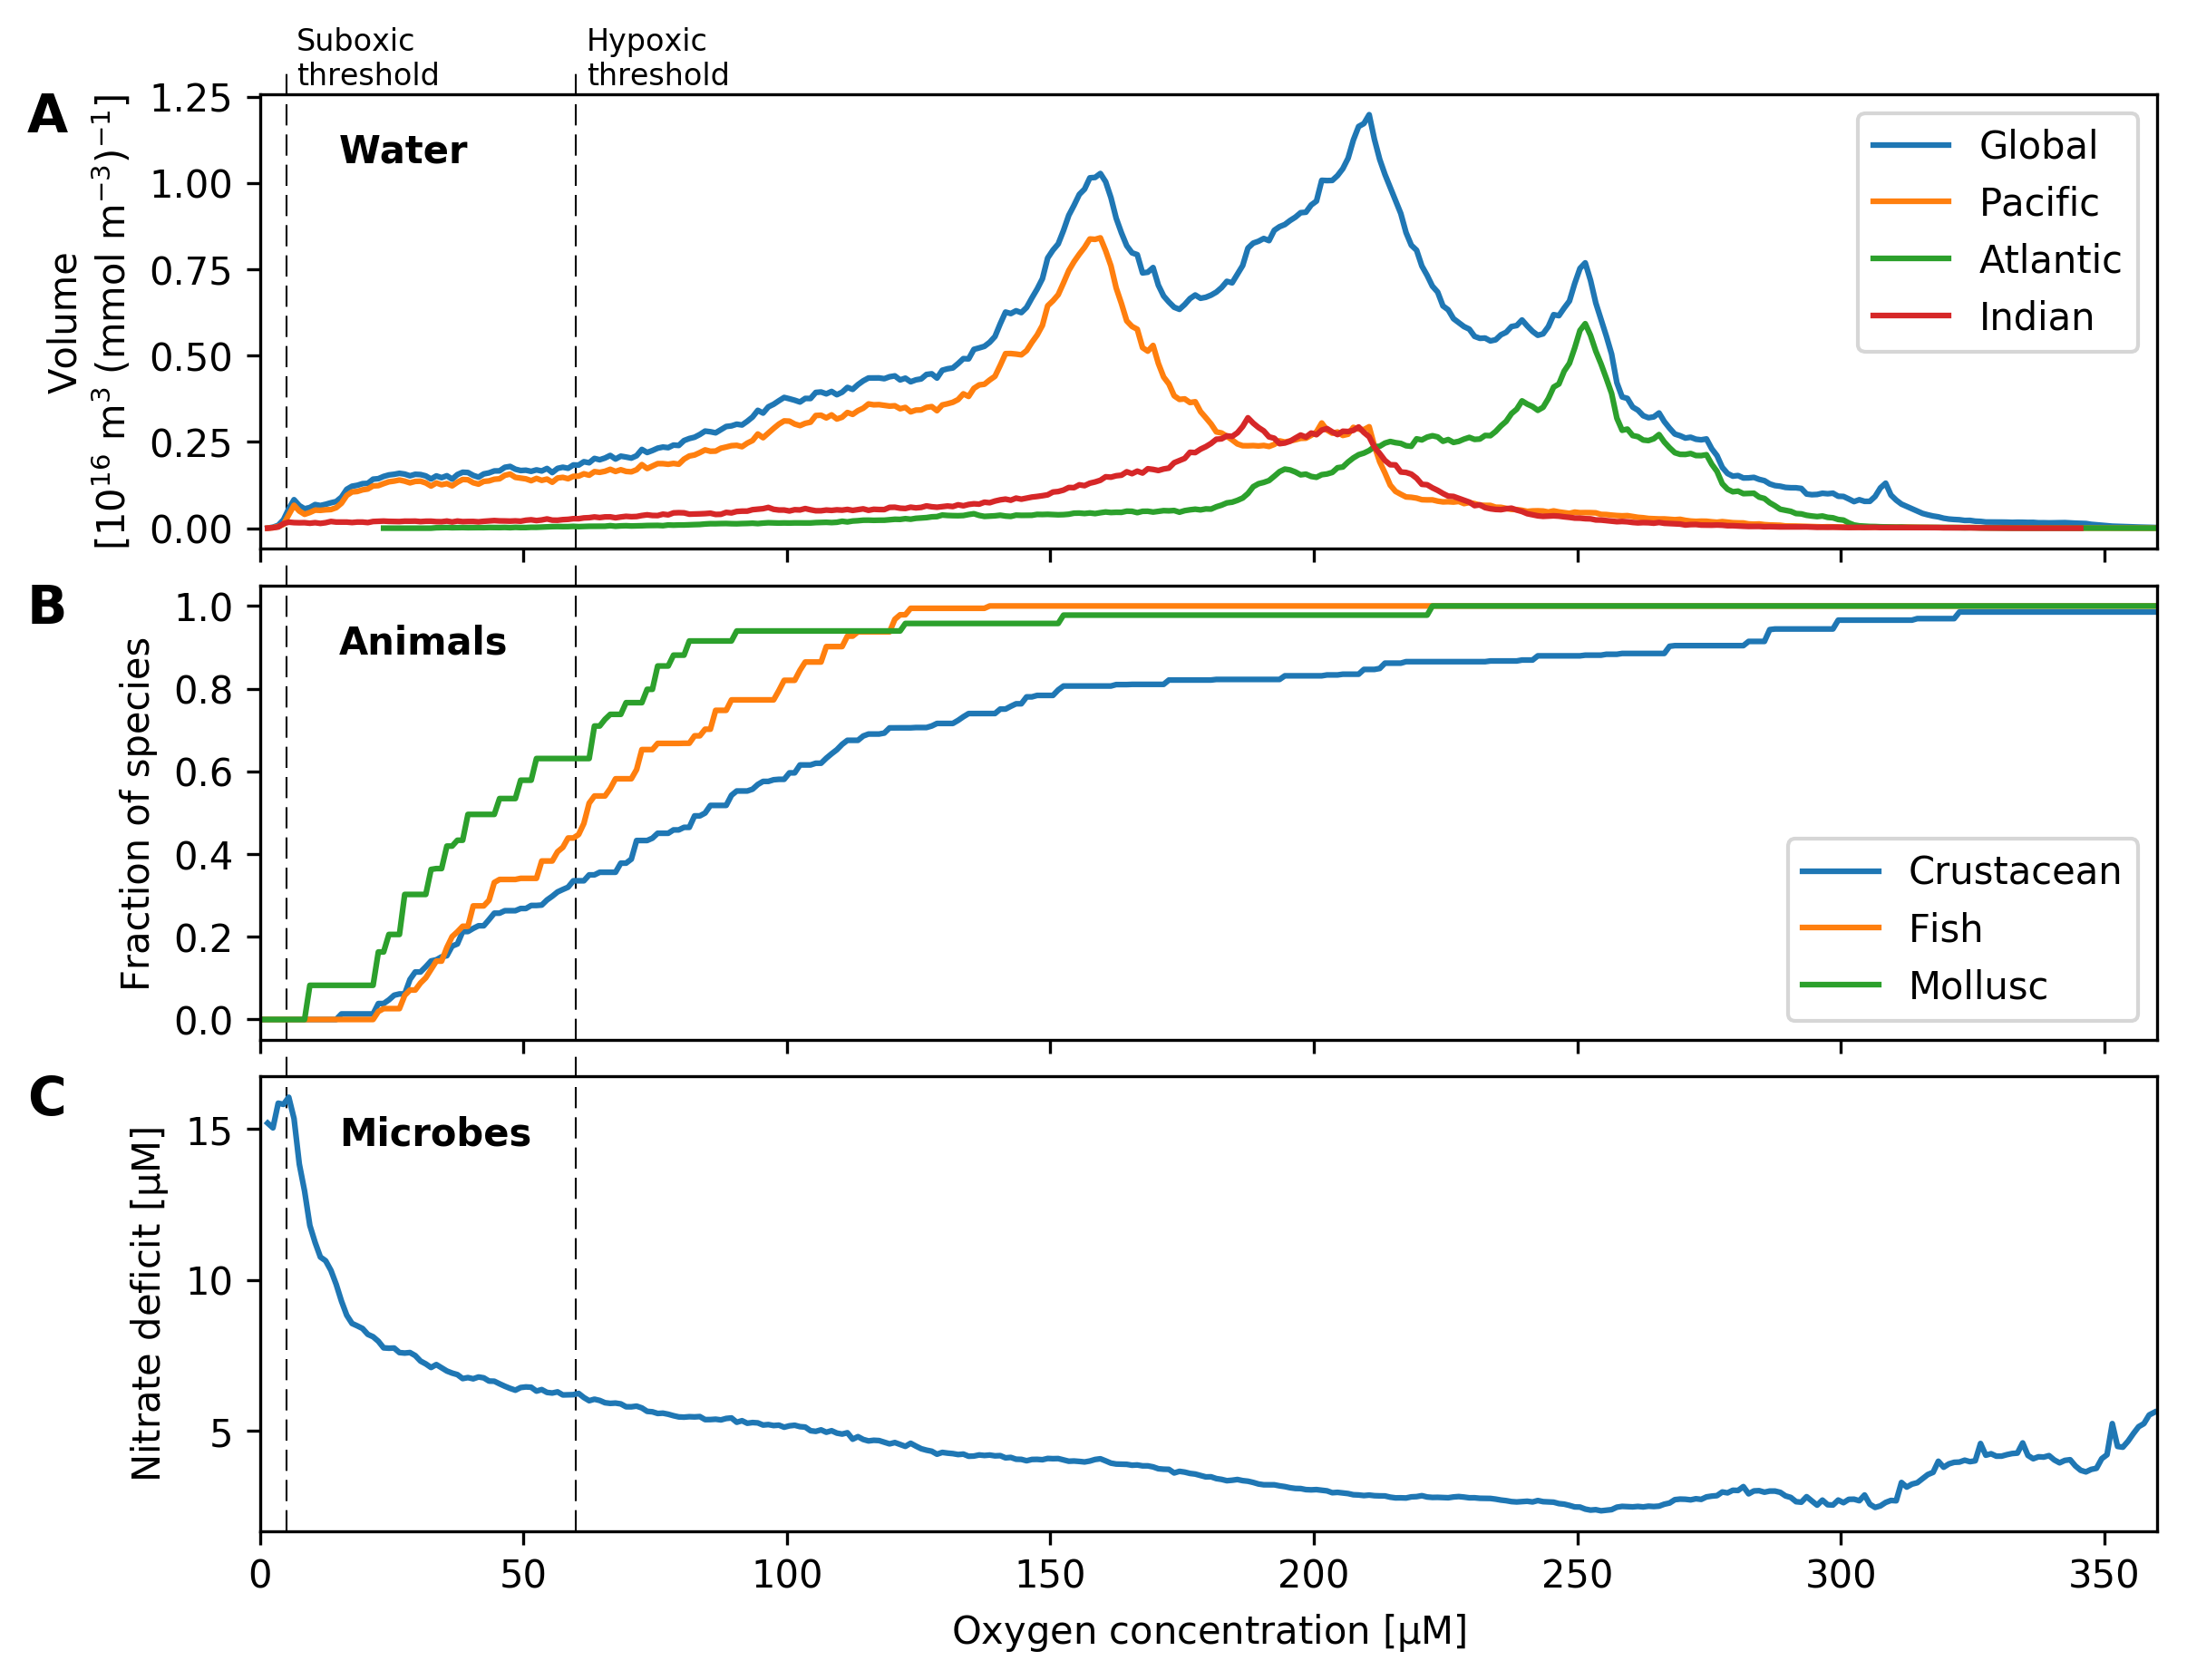

In [21]:
plot_name = os.path.join(diro['fig'],'woa_o2pdf_mortality_no3deficit.pdf')

fig = plt.figure(dpi=300,figsize=(9,7),facecolor='w')
gs = gridspec.GridSpec(3,1)

hypoxia = 60.
suboxia = 5.

#----------------------------------------------------------------------
#-- plot o2 pdf
#----------------------------------------------------------------------
ax = fig.add_subplot(gs[0,0])
for name in ['Global','Pacific','Atlantic','Indian']:
    ax.plot(o2_binc,vol_by_o2[name]*1e-16,label=name)

ax.set_ylabel('Volume\n[10$^{16}$ m$^3$ (mmol m$^{-3}$)$^{-1}$]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_xticklabels([])
ax.set_xlim((o2_bins[0],o2_bins[-1]))
ylm = ax.get_ylim()

ax.text(15,ylm[1]-0.15*np.diff(ylm),'Water',fontweight='bold')

ax.axvline(x=hypoxia,ymax=1.06,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)
ax.axvline(x=suboxia,ymax=1.05,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)

ax.text(hypoxia+2,ylm[1]+0.02*np.diff(ylm), 'Hypoxic\nthreshold',fontsize=8)
ax.text(suboxia+2,ylm[1]+0.02*np.diff(ylm), 'Suboxic\nthreshold',fontsize=8)

#----------------------------------------------------------------------
#-- plot mortality pdfs    
#----------------------------------------------------------------------
ax = fig.add_subplot(gs[1,0])
for i,name in enumerate(mortality_thresholds.phyla.values):
    print name
    ax.plot(mortality_thresholds.o2bin,mortality_thresholds.hypoxic_cdf[i,:],'-',label=name)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xticklabels([])
ax.set_ylabel('Fraction of species')
ax.set_xlim((o2_bins[0],o2_bins[-1]))
ylm = ax.get_ylim()
ax.text(15,ylm[1]-0.15*np.diff(ylm),'Animals',fontweight='bold')

ax.axvline(x=hypoxia,ymax=1.06,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)
ax.axvline(x=suboxia,ymax=1.05,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)

#----------------------------------------------------------------------
#-- plot no3 deficit
#----------------------------------------------------------------------
ax = fig.add_subplot(gs[2,0])
for name in ['Global']:
    ax.plot(o2_binc,-no3def_by_o2[name]) 

ax.set_ylabel('Nitrate deficit [$\mu$M]')
ax.set_xlabel('Oxygen concentration [$\mu$M]')
ax.set_xlim((o2_bins[0],o2_bins[-1]))
ylm = ax.get_ylim()
ax.text(15,ylm[1]-0.15*np.diff(ylm),'Microbes',fontweight='bold')

ax.axvline(x=hypoxia,ymax=1.06,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)
ax.axvline(x=suboxia,ymax=1.05,color='k',linewidth=0.5,linestyle='--',zorder=-10,clip_on=False)

gs.update(hspace=0.08)  

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1-0.02
    fig.text(0.03,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')

plt.savefig(plot_name,bbox_inches='tight')